# Tyche Example for Simple Electrolysis

## Set up.

### One only needs to execute the following line once, in order to make sure recent enough packages are installed.

In [1]:
#!pip install 'numpy>=1.17.2' 'pandas>=0.25.1'

### Import packages.

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath("../../../src"))

In [3]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import re                as re
import scipy.stats       as st
import seaborn           as sb

# The `tyche` package is located at <https://github.com/NREL/portfolio/tree/master/production-function/framework/src/tyche/>.
import tyche             as ty

from copy import deepcopy

## Load data.

### The data are stored in a set of tab-separated value files in a folder.

In [4]:
designs = ty.Designs(path = ".",
                     name = 'simple-electrolysis.xlsx')

In [5]:
investments = ty.Investments(path = ".",
                             name = 'simple-electrolysis.xlsx')

### Compile the production and metric functions for each technology in the dataset.

In [6]:
designs.compile()

## Examine the data.

### The `functions` table specifies where the Python code for each technology resides.

In [7]:
designs.functions

,Style,Model,Capital,Fixed,Production,Metrics,Notes
Technology,,,,,,,
Simple electrolysis,numpy,simple_electrolysis,capital_cost,fixed_cost,production,metrics,NaN


Right now, only the style `numpy` is supported.

### The `indices` table defines the subscripts for variables.

In [8]:
designs.indices

Offset               Description  \
Technology          Type    Index                                           
Simple electrolysis Capital Catalyst          0                  Catalyst   
                    Input   Electricity       1               Electricity   
                            Water             0                     Water   
                    Metric  Cost              0                      Cost   
                            GHG               2  Greenhouse gas emissions   
                            Jobs              1                      Jobs   
                    Output  Hydrogen          1                  Hydrogen   
                            Oxygen            0                    Oxygen   

                                        Notes  
Technology          Type    Index              
Simple electrolysis Capital Catalyst      NaN  
                    Input   Electricity   NaN  
                            Water         NaN  
                    Metric  Cost          NaN  
                            GHG           NaN  
                            Jobs          NaN  
                    Output  Hydrogen      NaN  
                            Oxygen        NaN

### The `designs` table contains the cost, input, efficiency, and price data for a scenario.

In [9]:
designs.designs

Value  \
Technology          Tranche                           Variable          Index                                                       
Simple electrolysis Base Electrolysis                 Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity                                          0.85   
                                                                        Water                                                0.95   
                                                      Input price       Electricity                                      3.33e-05   
                                                                        Water                                              0.0048   
                                                      Lifetime          Catalyst                                                3   
                                                      Output efficiency Hydrogen                                              0.9   
                                                                        Oxygen                                                0.9   
                                                      Output price      Hydrogen                                             0.01   
                                                                        Oxygen                                              0.003   
                                                      Scale             Catalyst                                             6650   
                    Fast Progress on Electrolysis     Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity  st.truncnorm(-3, 0.75, loc=0.97, scale=0.04)   
                                                                        Water           st.truncnorm(-3, 2, loc=0.97, scale=0.01)   
                                                      Input price       Electricity                                      3.33e-05   
                                                                        Water                                              0.0048   
                                                      Lifetime          Catalyst                                                3   
                                                      Output efficiency Hydrogen              st.beta(3, 2, loc=0.90, scale=0.03)   
                                                                        Oxygen                st.beta(3, 2, loc=0.90, scale=0.06)   
                                                      Output price      Hydrogen                                             0.01   
                                                                        Oxygen                                              0.003   
                                                      Scale             Catalyst                                             6650   
                    Moderate Progress on Electrolysis Input             Electricity                                           279   
                                                                        Water                                               19.04   
                                                      Input efficiency  Electricity  st.truncnorm(-2, 1.75, loc=0.93, scale=0.04)   
                                                                        Water           st.truncnorm(-2, 3, loc=0.97, scale=0.01)   
                                                      Input price       Electricity                                      3.33e-05   
 

### The `parameters` table contains additional techno-economic parameters for each technology.

In [10]:
designs.parameters

Offset  \
Technology          Tranche                           Parameter                                     
Simple electrolysis Base Electrolysis                 Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Fast Progress on Electrolysis     Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Moderate Progress on Electrolysis Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                      Reference scale                           5   
                                                      Water consumption                         2   
                    Slow Progress on Electrolysis     Electricity consumption                   3   
                                                      GHG factor for electricity                9   
                                                      GHG factor for water                      8   
                                                      Hydrogen production                       1   
                                                      Jobs                                      4   
                                                      Oxygen production                         0   
                                                      Reference capital cost for catalyst       6   
                                                      Reference fixed cost for rent             7   
                                                   

### The `results` table specifies the units of measure for results of computations.

In [11]:
designs.results

Units Notes
Technology          Variable Index                    
Simple electrolysis Cost     Cost       USD/mole   NaN
                    Metric   Cost        USD/gH2   NaN
                             GHG       gCO2e/gH2   NaN
                             Jobs        job/gH2   NaN
                    Output   Hydrogen     g/mole   NaN
                             Oxygen       g/mole   NaN

### The `tranches` table specifies multually exclusive possibilities for investments: only one `Tranch` may be selected for each `Cateogry`.

In [12]:
investments.tranches

Amount Notes
Category         Tranche                                         
Electrolysis R&D Base Electrolysis                        0   NaN
                 Fast Progress on Electrolysis      5000000   NaN
                 Moderate Progress on Electrolysis  2500000   NaN
                 Slow Progress on Electrolysis      1000000   NaN

### The `investments` table bundles a consistent set of tranches (one per category) into an overall investment.

In [13]:
investments.investments

,,,Notes
Investment,Category,Tranche,
High R&D Spending,Electrolysis R&D,Fast Progress on Electrolysis,NaN
Low R&D Spending,Electrolysis R&D,Slow Progress on Electrolysis,NaN
Medium R&D Spending,Electrolysis R&D,Moderate Progress on Electrolysis,NaN
No R&D Spending,Electrolysis R&D,Base Electrolysis,NaN


## Evaluate the tranches in the dataset.

In [14]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50).metrics

Evaluating Simple electrolysis


In [15]:
tranche_results.xs(1, level="Sample", drop_level=False)

Value  \
Category         Tranche                           Sample Technology          Index              
Electrolysis R&D Base Electrolysis                 1      Simple electrolysis Cost    0.102121   
                                                                              GHG    21.391959   
                                                                              Jobs    0.000083   
                 Fast Progress on Electrolysis     1      Simple electrolysis Cost    0.099218   
                                                                              GHG    20.818873   
                                                                              Jobs    0.000081   
                 Moderate Progress on Electrolysis 1      Simple electrolysis Cost    0.100034   
                                                                              GHG    20.993416   
                                                                              Jobs    0.000082   
                 Slow Progress on Electrolysis     1      Simple electrolysis Cost    0.097861   
                                                                              GHG    20.450012   
                                                                              Jobs    0.000080   

                                                                                         Units  
Category         Tranche                           Sample Technology          Index             
Electrolysis R&D Base Electrolysis                 1      Simple electrolysis Cost     USD/gH2  
                                                                              GHG    gCO2e/gH2  
                                                                              Jobs     job/gH2  
                 Fast Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                              GHG    gCO2e/gH2  
                                                                              Jobs     job/gH2  
                 Moderate Progress on Electrolysis 1      Simple electrolysis Cost     USD/gH2  
                                                                              GHG    gCO2e/gH2  
                                                                              Jobs     job/gH2  
                 Slow Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                              GHG    gCO2e/gH2  
                                                                              Jobs     job/gH2

### Save results.

In [16]:
#tranche_results.to_csv("example-tranches.csv")

### Plot GHG metric.

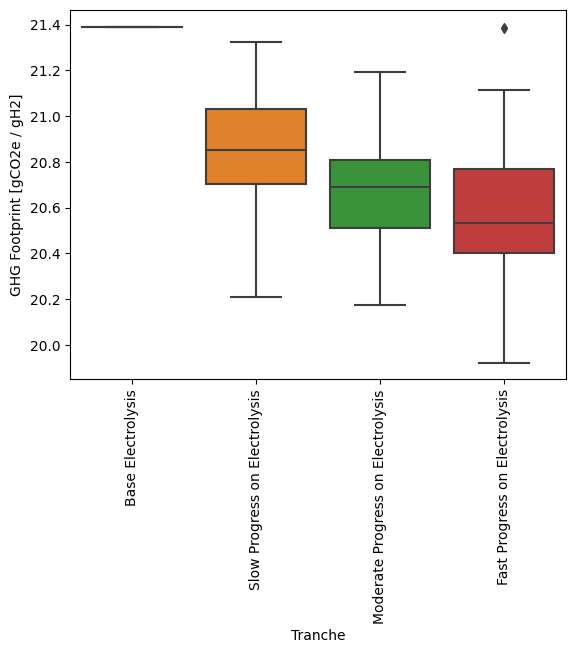

In [17]:
g = sb.boxplot(
    x="Tranche",
    y="Value",
    data=tranche_results.xs(
        "GHG",
        level="Index"
    ).reset_index()[["Tranche", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="GHG Footprint [gCO2e / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Plot cost metric.

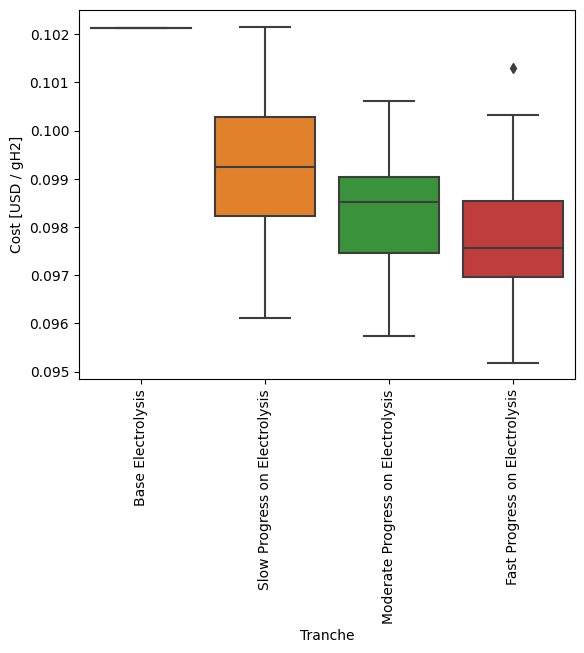

In [18]:
g = sb.boxplot(
    x="Tranche",
    y="Value",
    data=tranche_results.xs(
        "Cost",
        level="Index"
    ).reset_index()[["Tranche", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="Cost [USD / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Plot employment metric.

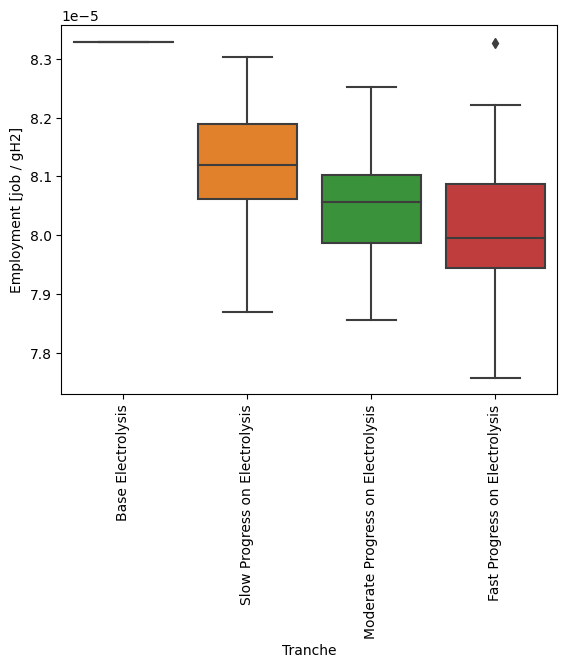

In [19]:
g = sb.boxplot(
    x="Tranche",
    y="Value",
    data=tranche_results.xs(
        "Jobs",
        level="Index"
    ).reset_index()[["Tranche", "Value"]],
    order=["Base Electrolysis", "Slow Progress on Electrolysis", "Moderate Progress on Electrolysis", "Fast Progress on Electrolysis"]
)
g.set(ylabel="Employment [job / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Evaluate the investments in the dataset.

In [20]:
investment_results = investments.evaluate_investments(designs, sample_count=50)

Evaluating Simple electrolysis
Evaluating Simple electrolysis


### Costs of investments.

In [21]:
investment_results.amounts

,Amount
Investment,
High R&D Spending,5000000.0
Low R&D Spending,1000000.0
Medium R&D Spending,2500000.0
No R&D Spending,0.0


### Benefits of investments.

In [22]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment          Category         Tranche                           Sample Technology          Index              
No R&D Spending     Electrolysis R&D Base Electrolysis                 1      Simple electrolysis Cost    0.102121   
                                                                                                  GHG    21.391959   
                                                                                                  Jobs    0.000083   
High R&D Spending   Electrolysis R&D Fast Progress on Electrolysis     1      Simple electrolysis Cost    0.098559   
                                                                                                  GHG    20.824343   
                                                                                                  Jobs    0.000081   
Medium R&D Spending Electrolysis R&D Moderate Progress on Electrolysis 1      Simple electrolysis Cost    0.098236   
                                                                                                  GHG    20.599165   
                                                                                                  Jobs    0.000080   
Low R&D Spending    Electrolysis R&D Slow Progress on Electrolysis     1      Simple electrolysis Cost    0.099878   
                                                                                                  GHG    20.971332   
                                                                                                  Jobs    0.000082   

                                                                                                             Units  
Investment          Category         Tranche                           Sample Technology          Index             
No R&D Spending     Electrolysis R&D Base Electrolysis                 1      Simple electrolysis Cost     USD/gH2  
                                                                                                  GHG    gCO2e/gH2  
                                                                                                  Jobs     job/gH2  
High R&D Spending   Electrolysis R&D Fast Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                                                  GHG    gCO2e/gH2  
                                                                                                  Jobs     job/gH2  
Medium R&D Spending Electrolysis R&D Moderate Progress on Electrolysis 1      Simple electrolysis Cost     USD/gH2  
                                                                                                  GHG    gCO2e/gH2  
                                                                                                  Jobs     job/gH2  
Low R&D Spending    Electrolysis R&D Slow Progress on Electrolysis     1      Simple electrolysis Cost     USD/gH2  
                                                                                                  GHG    gCO2e/gH2  
                                                                                                  Jobs     job/gH2

In [23]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value      Units
Investment          Technology          Sample Index                      
High R&D Spending   Simple electrolysis 1      Cost    0.098559    USD/gH2
                                               GHG    20.824343  gCO2e/gH2
                                               Jobs    0.000081    job/gH2
Low R&D Spending    Simple electrolysis 1      Cost    0.099878    USD/gH2
                                               GHG    20.971332  gCO2e/gH2
                                               Jobs    0.000082    job/gH2
Medium R&D Spending Simple electrolysis 1      Cost    0.098236    USD/gH2
                                               GHG    20.599165  gCO2e/gH2
                                               Jobs    0.000080    job/gH2
No R&D Spending     Simple electrolysis 1      Cost    0.102121    USD/gH2
                                               GHG    21.391959  gCO2e/gH2
                                               Jobs    0.000083    job/gH2

### Save results.

In [24]:
#investment_results.amounts.to_csv("example-investment-amounts.csv")

In [25]:
#investment_results.metrics.to_csv("example-investment-metrics.csv")

### Plot GHG metric.

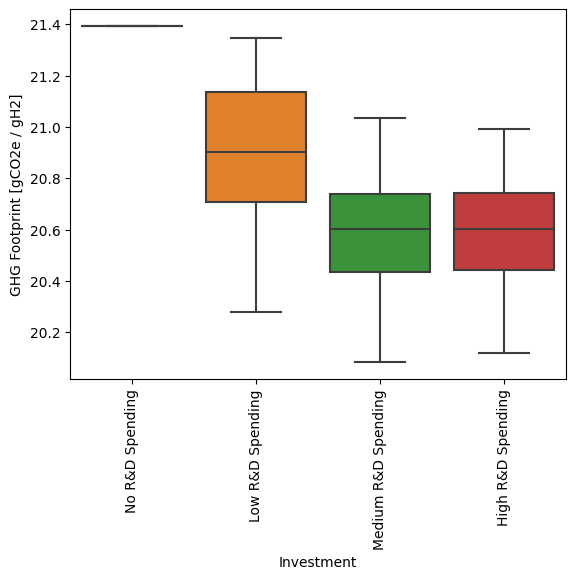

In [26]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "GHG",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="GHG Footprint [gCO2e / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Plot cost metric.

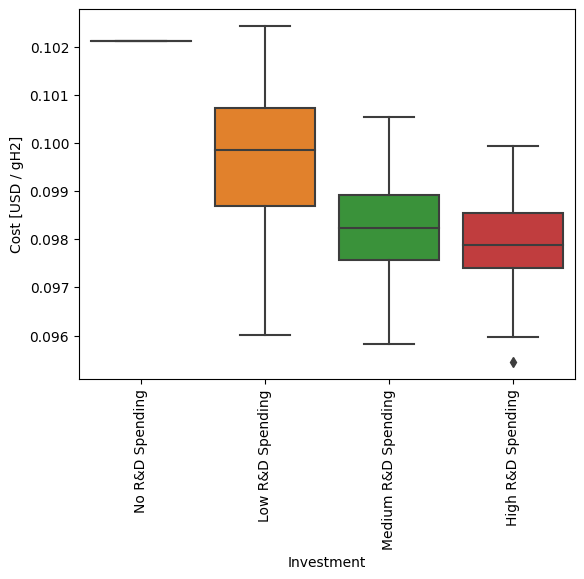

In [27]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Cost",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="Cost [USD / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

### Plot employment metric.

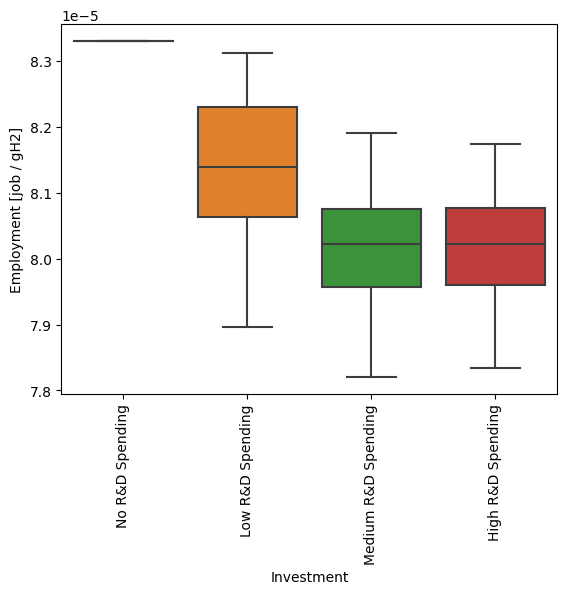

In [28]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Jobs",
        level="Index"
    ).reset_index()[["Investment", "Value"]],
    order=["No R&D Spending", "Low R&D Spending", "Medium R&D Spending", "High R&D Spending"]
)
g.set(ylabel="Employment [job / gH2]")
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Sensitity analysis.

### Vary the four efficiencies in the design.

In [29]:
# Four variables are involved.
variables = [
    ("Input efficiency" , "Water"      ),
    ("Input efficiency" , "Electricity"),
    ("Output efficiency", "Oxygen"     ),
    ("Output efficiency", "Hydrogen"   ),
]

In [30]:
# Let efficiencies range from 0.75 to 0.975.
efficiencies = np.arange(0.750, 1.000, 0.025)
efficiencies

array([0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 ,
       0.975])

### Start from the base case.

In [31]:
base_design = designs.designs.xs("Base Electrolysis", level=1, drop_level=False)
base_design

Value  \
Technology          Tranche           Variable          Index                   
Simple electrolysis Base Electrolysis Input             Electricity       279   
                                                        Water           19.04   
                                      Input efficiency  Electricity      0.85   
                                                        Water            0.95   
                                      Input price       Electricity  3.33e-05   
                                                        Water          0.0048   
                                      Lifetime          Catalyst            3   
                                      Output efficiency Hydrogen          0.9   
                                                        Oxygen            0.9   
                                      Output price      Hydrogen         0.01   
                                                        Oxygen          0.003   
                                      Scale             Catalyst         6650   

                                                                        Units  \
Technology          Tranche           Variable          Index                   
Simple electrolysis Base Electrolysis Input             Electricity   kJ/mole   
                                                        Water          g/mole   
                                      Input efficiency  Electricity         1   
                                                        Water               1   
                                      Input price       Electricity    USD/kJ   
                                                        Water        USD/mole   
                                      Lifetime          Catalyst           yr   
                                      Output efficiency Hydrogen            1   
                                                        Oxygen              1   
                                      Output price      Hydrogen        USD/g   
                                                        Oxygen          USD/g   
                                      Scale             Catalyst      mole/yr   

                                                                                                     Notes  
Technology          Tranche           Variable          Index                                               
Simple electrolysis Base Electrolysis Input             Electricity                                    NaN  
                                                        Water                                          NaN  
                                      Input efficiency  Electricity                                    NaN  
                                                        Water                                          NaN  
                                      Input price       Electricity                                    NaN  
                                                        Water                                          NaN  
                                      Lifetime          Catalyst     Effective lifetime of Al-Ni catalyst.  
                                      Output efficiency Hydrogen                                       NaN  
                                                        Oxygen                                         NaN  
                                      Output price      Hydrogen                                       NaN  
                                                        Oxygen                                         NaN  
                                      Scale             Catalyst           Rough estimate for a 50W setup.

In [32]:
base_parameters = designs.parameters.xs("Base Electrolysis", level=1, drop_level=False)
base_parameters

Offset  \
Technology          Tranche           Parameter                                     
Simple electrolysis Base Electrolysis Electricity consumption                   3   
                                      GHG factor for electricity                9   
                                      GHG factor for water                      8   
                                      Hydrogen production                       1   
                                      Jobs                                      4   
                                      Oxygen production                         0   
                                      Reference capital cost for catalyst       6   
                                      Reference fixed cost for rent             7   
                                      Reference scale                           5   
                                      Water consumption                         2   

                                                                             Value  \
Technology          Tranche           Parameter                                      
Simple electrolysis Base Electrolysis Electricity consumption                  237   
                                      GHG factor for electricity             0.138   
                                      GHG factor for water                 0.00108   
                                      Hydrogen production                        2   
                                      Jobs                                 0.00015   
                                      Oxygen production                         16   
                                      Reference capital cost for catalyst     0.63   
                                      Reference fixed cost for rent           1000   
                                      Reference scale                         6650   
                                      Water consumption                      18.08   

                                                                              Units  \
Technology          Tranche           Parameter                                       
Simple electrolysis Base Electrolysis Electricity consumption                    kJ   
                                      GHG factor for electricity           gCO2e/kJ   
                                      GHG factor for water                  gCO2e/g   
                                      Hydrogen production                         g   
                                      Jobs                                 job/mole   
                                      Oxygen production                           g   
                                      Reference capital cost for catalyst       USD   
                                      Reference fixed cost for rent          USD/yr   
                                      Reference scale                       mole/yr   
                                      Water consumption                           g   

                                                                                                          Notes  
Technology          Tranche           Parameter                                                                  
Simple electrolysis Base Electrolysis Electricity consumption                                               NaN  
                                      GHG factor for electricity                   based on 1 kWh = 0.5 kg CO2e  
                                      GHG factor for water                 based on 244,956 gallons = 1 Mg CO2e  
                                      Hydrogen production                                                   NaN  
                                      Jobs                                                                  NaN  
                                      Oxygen production                                                     NaN  
                                      Reference capital cost for

### Generate the new tranches and append them to the previous ones.

In [33]:
sensitivities = deepcopy(designs)
sensitivities.designs = sensitivities.designs[0:0]
sensitivities.parameters = sensitivities.parameters[0:0]

In [34]:
# Iterate over variables and efficiencies.
for variable, index in variables:
    for efficiency in efficiencies:

        # Name the tranche.
        tranche = "Let " + variable + " @ " + index + " = " + str(round(efficiency, 3))
        
        # Alter the base case.
        vary_design = base_design.rename(index={"Base Electrolysis" : tranche}, level=1)
        vary_design.loc[("Simple electrolysis", tranche, variable, index), "Value"] = efficiency
        
        # Keep the parameters the same.
        vary_parameters = base_parameters.rename(index={"Base Electrolysis" : tranche}, level=1)
        
        # Append the results to the existing table of scenarios.
        sensitivities.designs = pd.concat([sensitivities.designs, vary_design])
        sensitivities.parameters = pd.concat([sensitivities.parameters, vary_parameters])

#### Remember to compile the design, since we've added scenarios.

In [35]:
sensitivities.compile()

#### See how many rows there are in the tables now.

In [36]:
sensitivities.designs.shape

(480, 3)

In [37]:
sensitivities.parameters.shape

(400, 4)

In [38]:
sensitivities.designs

Value  \
Technology          Tranche                                  Variable          Index                   
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity       279   
                                                                               Water           19.04   
                                                             Input efficiency  Electricity      0.85   
                                                                               Water            0.75   
                                                             Input price       Electricity  3.33e-05   
...                                                                                              ...   
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen        0.975   
                                                                               Oxygen            0.9   
                                                             Output price      Hydrogen         0.01   
                                                                               Oxygen          0.003   
                                                             Scale             Catalyst         6650   

                                                                                              Units  \
Technology          Tranche                                  Variable          Index                  
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity  kJ/mole   
                                                                               Water         g/mole   
                                                             Input efficiency  Electricity        1   
                                                                               Water              1   
                                                             Input price       Electricity   USD/kJ   
...                                                                                             ...   
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen           1   
                                                                               Oxygen             1   
                                                             Output price      Hydrogen       USD/g   
                                                                               Oxygen         USD/g   
                                                             Scale             Catalyst     mole/yr   

                                                                                                                      Notes  
Technology          Tranche                                  Variable          Index                                         
Simple electrolysis Let Input efficiency @ Water = 0.75      Input             Electricity                              NaN  
                                                                               Water                                    NaN  
                                                             Input efficiency  Electricity                              NaN  
                                                                               Water                                    NaN  
                                                             Input price       Electricity                              NaN  
...                                                                                                                     ...  
                    Let Output efficiency @ Hydrogen = 0.975 Output efficiency Hydrogen                                 NaN  
                                                                               Oxygen                                   NaN  
                                                             Output price      Hydrogen                                 NaN  
                

### Compute the results.

In [39]:
results = sensitivities.evaluate_tranche_impacts(1)
results

Evaluating Simple electrolysis


Value  \
Technology          Tranche                                   Sample Variable Index                 
Simple electrolysis Let Input efficiency @ Electricity = 0.75 1      Cost     Cost       0.190164   
                                                                     Metric   Cost       0.119657   
                                                                              GHG       24.239606   
                                                                              Jobs       0.000094   
                                                                     Output   Hydrogen   1.589241   
...                                                                                           ...   
                    Let Output efficiency @ Oxygen = 0.975    1      Metric   Cost       0.100121   
                                                                              GHG       21.391959   
                                                                              Jobs       0.000083   
                                                                     Output   Hydrogen   1.800796   
                                                                              Oxygen    15.606903   

                                                                                            Units  
Technology          Tranche                                   Sample Variable Index                
Simple electrolysis Let Input efficiency @ Electricity = 0.75 1      Cost     Cost       USD/mole  
                                                                     Metric   Cost        USD/gH2  
                                                                              GHG       gCO2e/gH2  
                                                                              Jobs        job/gH2  
                                                                     Output   Hydrogen     g/mole  
...                                                                                           ...  
                    Let Output efficiency @ Oxygen = 0.975    1      Metric   Cost        USD/gH2  
                                                                              GHG       gCO2e/gH2  
                                                                              Jobs        job/gH2  
                                                                     Output   Hydrogen     g/mole  
                                                                              Oxygen       g/mole  

[240 rows x 2 columns]

### Plot the cost results.

In [40]:
cost_results = results.xs("Cost", level="Index").reset_index()[["Tranche", "Value"]]

In [41]:
cost_results[0:10]

,Tranche,Value
0,Let Input efficiency @ Electricity = 0.75,0.190164
1,Let Input efficiency @ Electricity = 0.75,0.119657
2,Let Input efficiency @ Electricity = 0.775,0.188595
3,Let Input efficiency @ Electricity = 0.775,0.114842
4,Let Input efficiency @ Electricity = 0.8,0.187026
5,Let Input efficiency @ Electricity = 0.8,0.110327
6,Let Input efficiency @ Electricity = 0.825,0.185457
7,Let Input efficiency @ Electricity = 0.825,0.106087
8,Let Input efficiency @ Electricity = 0.85,0.183900
9,Let Input efficiency @ Electricity = 0.85,0.102121


In [42]:
cost_results["Variable"  ] = cost_results["Tranche"].apply(lambda x: re.sub(r'^Let (.*) @ (.*) =.*$', '\\1[\\2]', x))
cost_results["Efficiency"] = cost_results["Tranche"].apply(lambda x: float(re.sub(r'^.*= (.*)$', '\\1', x)))
cost_results["Cost [USD/mole]"] = cost_results["Value"]

In [43]:
cost_results = cost_results[["Variable", "Efficiency", "Cost [USD/mole]"]]
cost_results[0:10]

,Variable,Efficiency,Cost [USD/mole]
0,Input efficiency[Electricity],0.750,0.190164
1,Input efficiency[Electricity],0.750,0.119657
2,Input efficiency[Electricity],0.775,0.188595
3,Input efficiency[Electricity],0.775,0.114842
4,Input efficiency[Electricity],0.800,0.187026
5,Input efficiency[Electricity],0.800,0.110327
6,Input efficiency[Electricity],0.825,0.185457
7,Input efficiency[Electricity],0.825,0.106087
8,Input efficiency[Electricity],0.850,0.183900
9,Input efficiency[Electricity],0.850,0.102121


<Axes: xlabel='Efficiency', ylabel='Cost [USD/mole]'>

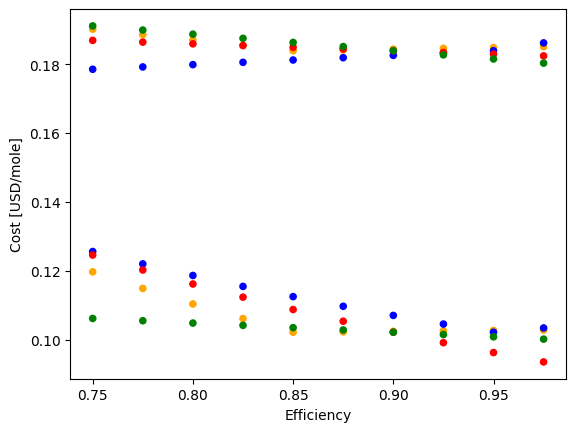

In [44]:
# Here is a really simple plot.
cost_results.plot(
    x="Efficiency",
    y="Cost [USD/mole]",
    c=cost_results["Variable"].apply(lambda v: {
        "Input efficiency[Water]"       : "blue"  ,
        "Input efficiency[Electricity]" : "orange",
        "Output efficiency[Oxygen]"     : "green" ,
        "Output efficiency[Hydrogen]"   : "red"   ,
    }[v]),
    kind="scatter"
)